### Imports

In [26]:
#Base
import pandas as pd
import numpy as np

#others

import itertools
import string
import re

#Visuals
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#warnings
import warnings
warnings.filterwarnings('ignore')

In [27]:
#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [28]:
#nltk
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk import WordNetLemmatizer, pos_tag

### CSV File - EDA

In [29]:
#loading csv file

df = pd.read_csv('/Users/kellyjara/Desktop/Project_4/Data/judge-1377884607_tweet_product_company.csv', 
                encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [30]:
# Viewing columns and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [31]:
# Renaming column for easier callback/reference

df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace = True)

In [32]:
#Viewing change 

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [33]:
#checking NaN values in columns

df.isna().sum()

tweet_text                            1
emotion_in_tweet_is_directed_at    5802
emotion                               0
dtype: int64

In [34]:
# Dropping column as it is not needed for sentiment analysis

df.drop(columns = 'emotion_in_tweet_is_directed_at', inplace = True)

In [35]:
# Dropping NaN values in the df
df.dropna(axis = 0, inplace = True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   emotion     9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


In [37]:
df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [38]:
# Dropping values that contain no emotion; Keeping only positive and negative emotions
df2 = df[df['emotion'] != "I can't tell"]
df2 = df2[df2['emotion'] != "No emotion toward brand or product"]

In [39]:
df2['emotion'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

In [40]:
# Creating emotion column into a numerical value
df2['target'] = df2['emotion'].astype('category')
categories = ['Positive emotion', 'Negative emotion']
df2['target'] = df2['target'].cat.reorder_categories(categories)
df2['target'] = df2['target'].cat.codes
df2['target'].value_counts()

0    2978
1     570
Name: target, dtype: int64

In [41]:
# Viewing 1st tweet in the df 
tweet_1 = df['tweet_text'].iloc[0]
tweet_1

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

<Axes: xlabel='emotion', ylabel='count'>

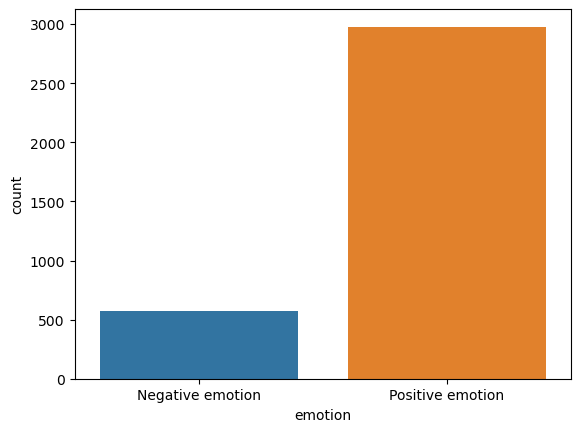

In [42]:
#Visualization of data distribution
sns.countplot(x = 'emotion', data = df2)

### Text PreProcessing 

In [43]:
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('JJ'):
            return wordnet.ADJ
        elif nltk_tag.startswith('VB'):
            return wordnet.VERB
        elif nltk_tag.startswith('NN'):
            return wordnet.NOUN
        elif nltk_tag.startswith('RB'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", 
                         tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    #removing special characters 
    tweet_spec = re.sub(r"[^a-zA-Z0-9 ]", "", tweet_lower)
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_spec) if ((x.isalpha()) & (x not in stop_words)) ]
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # rejoining lemmatized sentence 
    tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
    return tweet_norm

In [44]:
df2['norm_tweet'] = df2['tweet_text'].apply(process_tweet, args = [3])
df2

,tweet_text,emotion,target,norm_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,1,iphone hr tweet dead need upgrade plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,0,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,0,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,1,hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,0,great stuff fri mayer google tim oreilly tech ...
...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,Positive emotion,0,pr guy convince switch back iphone great coverage
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Positive emotion,0,quotpapyrussort ipadquot nice lol lavelle
9080,Diller says Google TV &quot;might be run over ...,Negative emotion,1,diller say google tv quotmight run playstation...
9085,I've always used Camera+ for my iPhone b/c it ...,Positive emotion,0,ive always use camera iphone bc image stabiliz...


In [45]:
df3 = df2['tweet_text'].apply(process_tweet, args = [3])
df3

0        iphone hr tweet dead need upgrade plugin station
1       know awesome ipadiphone app youll likely appre...
2                                          wait also sale
3          hope year festival isnt crashy year iphone app
4       great stuff fri mayer google tim oreilly tech ...
                              ...                        
9077    pr guy convince switch back iphone great coverage
9079            quotpapyrussort ipadquot nice lol lavelle
9080    diller say google tv quotmight run playstation...
9085    ive always use camera iphone bc image stabiliz...
9088                                 ipad everywhere link
Name: tweet_text, Length: 3548, dtype: object

### Wordcloud

In [21]:
from wordcloud import WordCloud

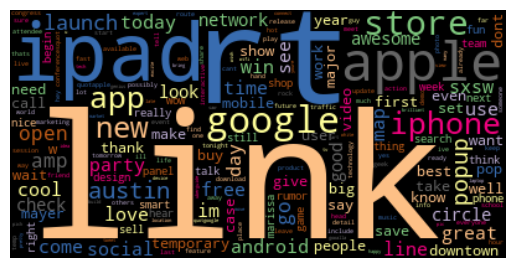

In [22]:
pos_text = " ".join(df2[df2['emotion'] == 'Positive emotion']['norm_tweet'])

word_cloud = WordCloud(collocations = False, background_color = 'black', colormap = 'Accent').generate(pos_text)

plt.imshow(word_cloud, interpolation = 'bilinear')

plt.axis('off')
plt.show()

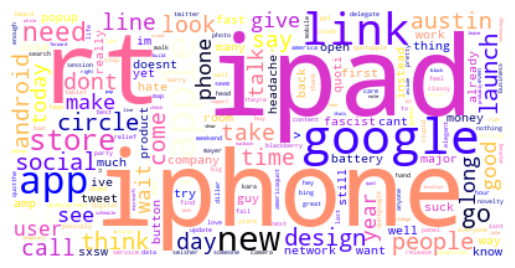

In [23]:
neg_text = " ".join(df2[df2['emotion'] == 'Negative emotion']['norm_tweet'])

word_cloud = WordCloud(collocations = False, background_color = 'white', colormap = 'gnuplot2').generate(neg_text)

plt.imshow(word_cloud, interpolation = 'bilinear')

plt.axis('off')
plt.show()

### Vectorizing

In [47]:
#Train-Test-Split
X = df2['norm_tweet']
y = df2['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [48]:
X_train

592     future google contextual discovery location co...
1084                 art show time check interactive fool
1275    apple austin store week downtown presence chan...
6353      rt new app store include uberguide sponsor link
5972    rt head austin austin guide free limited time ...
                              ...                        
4832    head austin wkend love set popup store amp con...
1459    brilliant marketing quotapple open temporary s...
4374                                really tempt get ipad
4135    spark select finalist team android choice awar...
1681                              available kill get link
Name: norm_tweet, Length: 2838, dtype: object

#### CountVectorizer

In [49]:
cv = CountVectorizer()
cv_X_train = cv.fit_transform(X_train)
cv_X_test= cv.transform(X_test)
cv.get_feature_names_out()

array(['aapl', 'abacus', 'abandon', ..., 'zone', 'zoom', 'zzzs'],
      dtype=object)

#### TfidfVectorizer

In [50]:
vec = TfidfVectorizer()

vec.fit(X_train)
X_train_vec = vec.transform(X_train)
X_test_vec = vec.transform(X_test)
 

pd.DataFrame(X_train_vec.toarray(), columns = vec.get_feature_names_out())

,aapl,abacus,abandon,aber,able,abroad,absolute,absolutely,abt,abuzz,...,ze,zeldman,zero,zite,zms,zombie,zomg,zone,zoom,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
len(vec.get_feature_names_out())
vec.get_feature_names_out()

array(['aapl', 'abacus', 'abandon', ..., 'zone', 'zoom', 'zzzs'],
      dtype=object)

### Topic Modeling

### topic modeling - gensim

In [52]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

In [53]:
top_mod = NMF(n_components = 2)
top_mod.fit(cv_X_train)

NMF(n_components=2)

In [54]:
H = top_mod.transform(cv_X_train)
W = top_mod.components_

print("Shape of W is" + str(W.shape))
print("Shape of H is" + str(H.shape))
print("Shape of train is" + str(cv_X_train.shape))

Shape of W is(2, 4221)
Shape of H is(2838, 2)
Shape of train is(2838, 4221)


In [55]:
# 2,838 tweets in this train set
# 3,598 features

In [56]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR Emotion{index}')
    print([vec.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR Emotion0
['temp', 'win', 'begin', 'go', 'shop', 'day', 'buy', 'sell', 'even', 'rt', 'launch', 'set', 'pop', 'sxsw', 'get', 'downtown', 'temporary', 'line', 'open', 'austin', 'popup', 'ipad', 'link', 'store', 'apple']


THE TOP 10 WORDS FOR Emotion1
['cool', 'free', 'possibly', 'map', 'time', 'android', 'come', 'party', 'amp', 'major', 'go', 'call', 'get', 'today', 'network', 'circle', 'social', 'launch', 'app', 'iphone', 'new', 'ipad', 'google', 'link', 'rt']




In [57]:
vec_df = pd.DataFrame(cv_X_train.toarray(), columns = cv.get_feature_names_out())
vec_df['target'] = y_train
vec_df

,aapl,abacus,abandon,aber,able,abroad,absolute,absolutely,abt,abuzz,...,ze,zeldman,zero,zite,zms,zombie,zomg,zone,zoom,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
vec_df['target'].value_counts()

0.0    771
1.0    150
Name: target, dtype: int64

In [59]:
vec_df.iloc[200].sort_values(ascending = False)[:10]

digital    2.0
guitar     1.0
record     1.0
fan        1.0
iphone     1.0
lovin      1.0
sings      1.0
app        1.0
band       1.0
vids       1.0
Name: 200, dtype: float64

### Model Eval - CtVectorizer

#### Model imports

In [60]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score

### Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression

              precision    recall  f1-score   support

           0       0.89      0.98      0.94       598
           1       0.81      0.38      0.51       112

    accuracy                           0.89       710
   macro avg       0.85      0.68      0.72       710
weighted avg       0.88      0.89      0.87       710



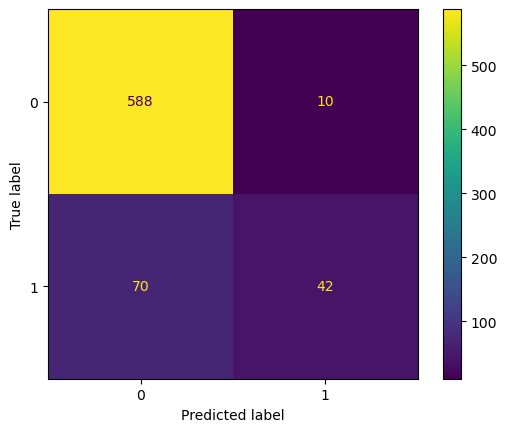

In [62]:
logreg = LogisticRegression()

logreg.fit(cv_X_train, y_train)
preds = logreg.predict(cv_X_test)

print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
cmp = ConfusionMatrixDisplay(cm).plot()

In [63]:
print(logreg.score(cv_X_train, y_train))
print(logreg.score(cv_X_test, y_test))

0.9654686398872445
0.8873239436619719


In [64]:
roc_auc_score(y_test, preds)

0.6791387959866221

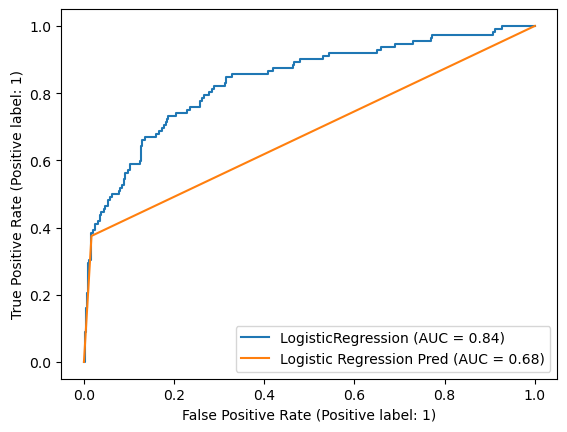

In [65]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(logreg, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, preds ,ax=ax,name="Logistic Regression Pred")

### Bernoulli model 

In [66]:
from sklearn.naive_bayes import BernoulliNB

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       598
           1       0.87      0.24      0.38       112

    accuracy                           0.87       710
   macro avg       0.87      0.62      0.65       710
weighted avg       0.87      0.87      0.84       710



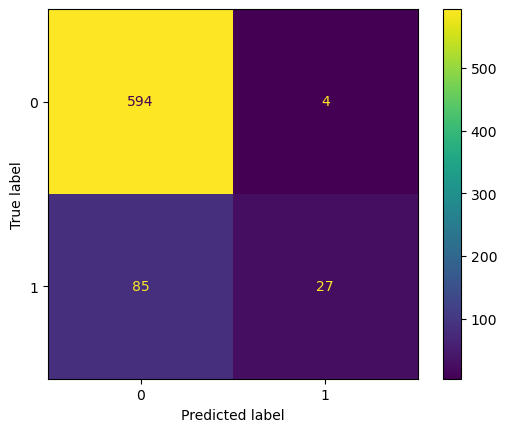

In [67]:
bn_model = BernoulliNB()
bn_model.fit(cv_X_train, y_train)
bn_pred = bn_model.predict(cv_X_test)

print(classification_report(y_test, bn_pred))

bn_cm = confusion_matrix(y_test, bn_pred)
ConfusionMatrixDisplay(bn_cm).plot()

In [68]:
print(bn_model.score(cv_X_train, y_train))
print(bn_model.score(cv_X_test, y_test))

0.908738548273432
0.8746478873239436


In [69]:
roc_auc_score(y_test, bn_pred)

0.6171912326803631

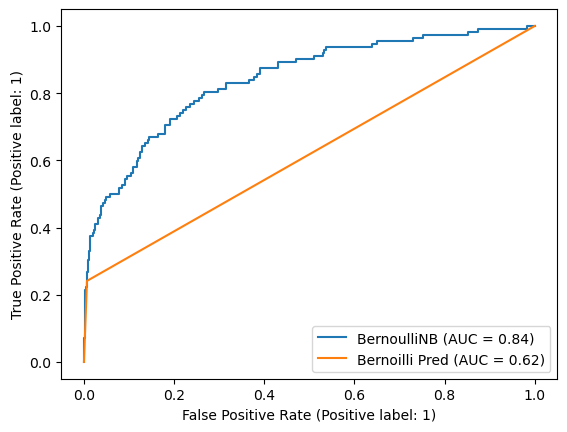

In [70]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(bn_model, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, bn_pred ,ax=ax,name="Bernoilli Pred")

### Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       598
           1       0.00      0.00      0.00       112

    accuracy                           0.84       710
   macro avg       0.42      0.50      0.46       710
weighted avg       0.71      0.84      0.77       710



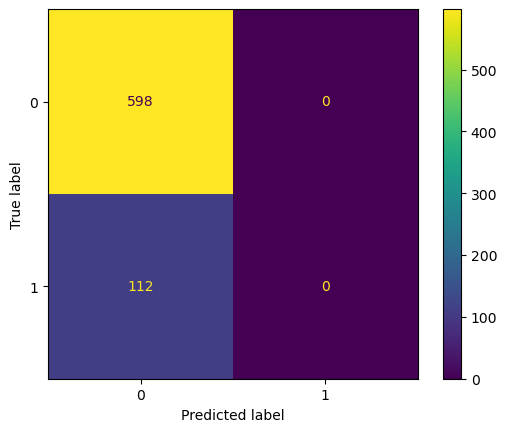

In [72]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 5)
rf.fit(cv_X_train, y_train)
rf_pred = rf.predict(cv_X_test)

print(classification_report(y_test, rf_pred))

rf_cm = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(rf_cm).plot()

In [73]:
print(rf.score(cv_X_train, y_train))
print(rf.score(cv_X_test, y_test))

0.8386187455954898
0.8422535211267606


In [74]:
roc_auc_score(y_test, rf_pred)

0.5

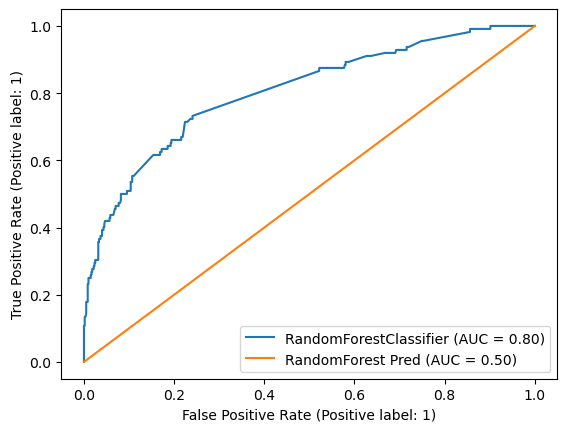

In [77]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(rf, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, rf_pred ,ax=ax,name="RandomForest Pred")

In [123]:
importance = rf.feature_importances_
importance

array([0.        , 0.00118272, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [140]:
top_10_indices = np.argsort(importance)[::-1][:10]

In [144]:
top_10_importances = importance[top_10_indices]
top_10_features = np.arange(cv_X_train.shape[1])[top_10_indices]

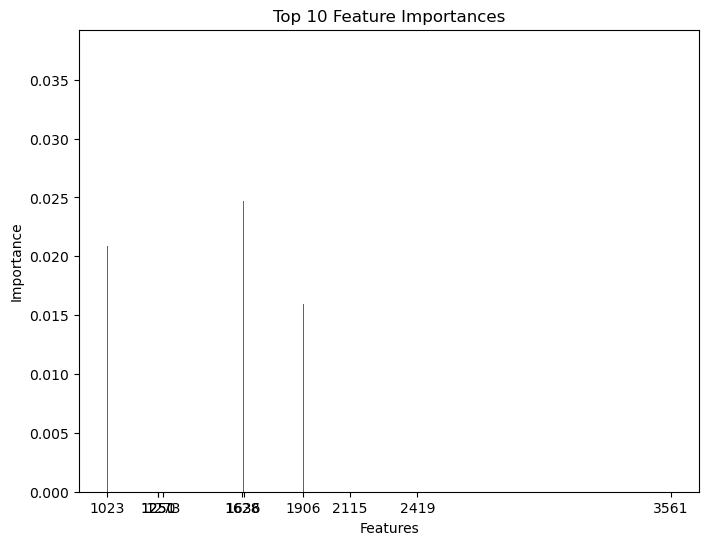

In [145]:
plt.figure(figsize=(8, 6))
plt.bar(top_10_features, top_10_importances)
plt.xticks(top_10_features)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')

plt.show()

### Naive Bayes

In [79]:
from sklearn.naive_bayes import MultinomialNB

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       598
           1       0.74      0.46      0.57       112

    accuracy                           0.89       710
   macro avg       0.82      0.72      0.75       710
weighted avg       0.88      0.89      0.88       710



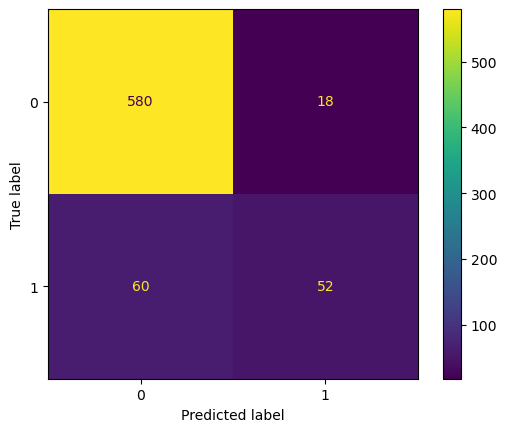

In [80]:
nb = MultinomialNB(alpha = 0.5)
nb.fit(cv_X_train, y_train)
nb_pred = nb.predict(cv_X_test)

print(classification_report(y_test, nb_pred))

nb_cm = confusion_matrix(y_test, nb_pred)
ConfusionMatrixDisplay(nb_cm).plot()

In [81]:
print(nb.score(cv_X_train, y_train))
print(nb.score(cv_X_test, y_test))

0.9570119802677942
0.8901408450704226


In [82]:
roc_auc_score(y_test, nb_pred)

0.717092689918777

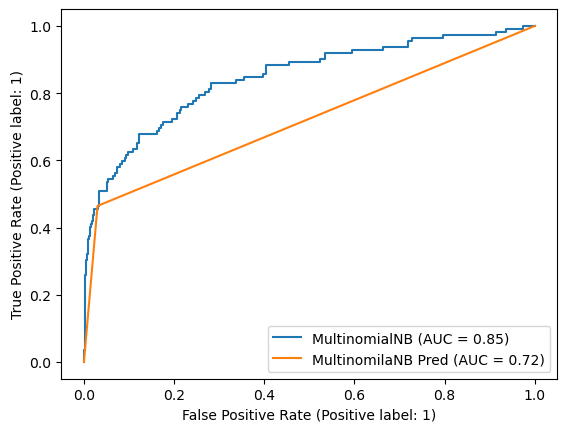

In [83]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(nb, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, nb_pred ,ax=ax,name="MultinomilaNB Pred")

### Compliment Naive Bayes

In [84]:
from sklearn.naive_bayes import ComplementNB

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       598
           1       0.57      0.59      0.58       112

    accuracy                           0.86       710
   macro avg       0.75      0.75      0.75       710
weighted avg       0.87      0.86      0.87       710



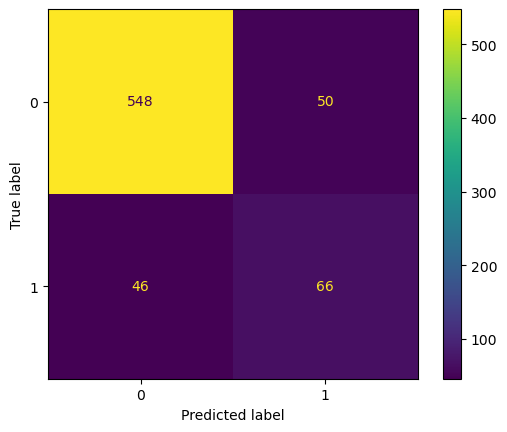

In [146]:
com_nb = ComplementNB(alpha = 0.05)
com_nb.fit(cv_X_train, y_train)
com_pred = com_nb.predict(cv_X_test)

print(classification_report(y_test, com_pred))

com_cm = confusion_matrix(y_test, com_pred)
ConfusionMatrixDisplay(com_cm).plot()

In [156]:
y_scores = com_nb.predict_proba(cv_X_test)[:, 1]

In [158]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(com_pred, y_scores)

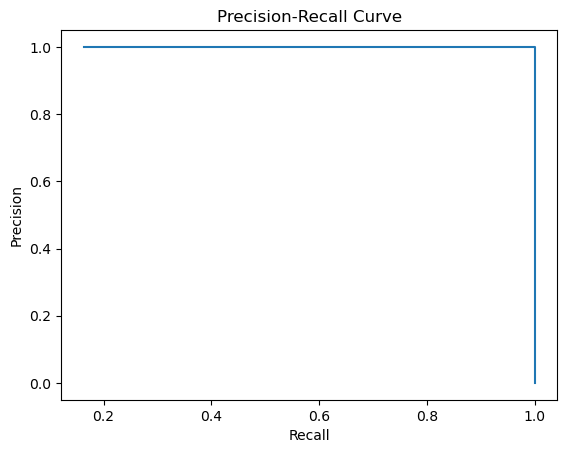

In [160]:
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.show()

In [86]:
accuracy = accuracy_score(y_test, com_pred)
print(f"Accuracy: {accuracy}") 

Accuracy: 0.8647887323943662


In [87]:
print(com_nb.score(cv_X_train, y_train))
print(com_nb.score(cv_X_test, y_test))

0.963706835799859
0.8647887323943662


In [88]:
roc_auc_score(y_test, com_pred)

0.7528368370759676

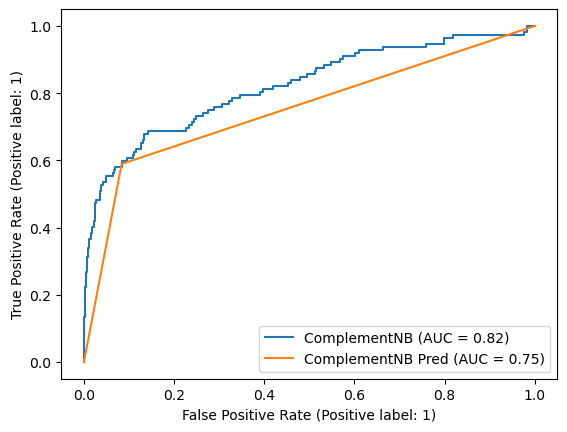

In [89]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(com_nb, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, com_pred ,ax=ax,name="ComplementNB Pred")

### Tuning

#### Imports

In [90]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

#### GridSearch

In [91]:
param_grid = {
    "gamma": [0.1, 1.0, 10, 100],
    "C": [0.1, 1.0, 10, 100]
}

In [92]:
grid_search = GridSearchCV(SVC(), param_grid, verbose=2)
grid_search.fit(cv_X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.6s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.6s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.7s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.6s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.7s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.7s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.7s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.6s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.6s
[CV] END ....................................C=0.1, gamma=10; total time=   0.7s
[CV] END ....................................C=0

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1.0, 10, 100],
                         'gamma': [0.1, 1.0, 10, 100]},
             verbose=2)

In [93]:
grid_search.best_params_

{'C': 10, 'gamma': 0.1}

In [94]:
grid_search.best_score_

0.8756203890006706

In [95]:
print(grid_search.score(cv_X_train, y_train))
print(grid_search.score(cv_X_test, y_test))

0.9989429175475687
0.8901408450704226


In [96]:
grid_search.predict(cv_X_test)

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [97]:
gs_best_model = grid_search.best_estimator_
gs_best_model

SVC(C=10, gamma=0.1)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       598
           1       0.85      0.37      0.51       112

    accuracy                           0.89       710
   macro avg       0.87      0.68      0.73       710
weighted avg       0.89      0.89      0.87       710



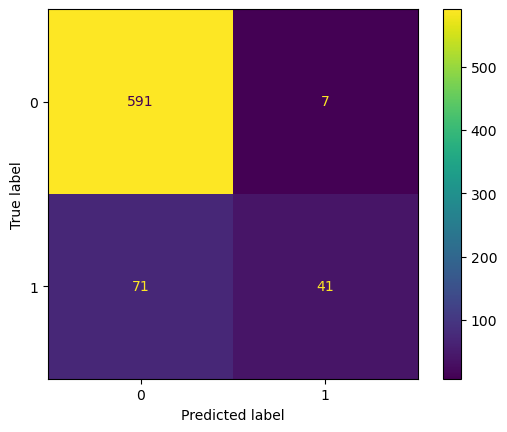

In [98]:
gs_fit = gs_best_model.fit(cv_X_train, y_train)
gs_pred = gs_fit.predict(cv_X_test)

print(classification_report(y_test, gs_pred))

gs_cm = confusion_matrix(y_test, gs_pred)
ConfusionMatrixDisplay(gs_cm).plot()

In [99]:
accuracy = accuracy_score(y_test, gs_pred)
print(f"Accuracy: {accuracy}") # Accuracy: 0.91

Accuracy: 0.8901408450704226


In [100]:
roc_auc_score(y_test, gs_pred)

0.6771828714763497

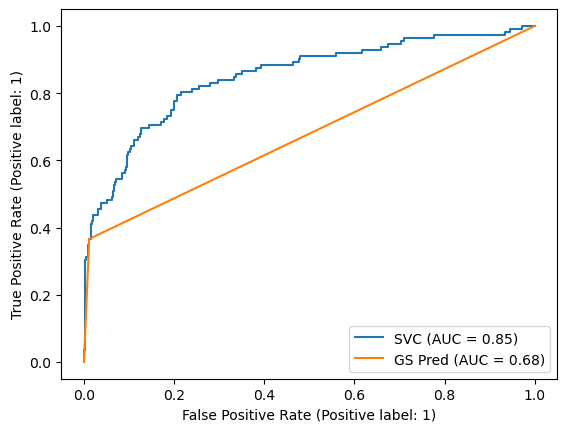

In [101]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(gs_best_model, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, gs_pred ,ax=ax,name="GS Pred")

#### Random hyperparameter opt

In [102]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [103]:
model = GradientBoostingRegressor()
parameters = {'learning_rate': [1e-5, .001, .01 , .1],
                  'subsample'    : sp_randFloat(),
                  'n_estimators' : sp_randInt(100, 1000),
                  'max_depth'    : sp_randInt(4, 12)
                 }

In [104]:
randm_src = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 10, n_jobs=-1)
randm_src.fit(cv_X_train, y_train)

RandomizedSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [1e-05, 0.001, 0.01,
                                                          0.1],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbea8ad1ed0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbea8ad1000>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbea8ad03d0>})

In [105]:
randm_src.best_estimator_

GradientBoostingRegressor(learning_rate=0.001, max_depth=10, n_estimators=444,
                          subsample=0.35167213496210037)

In [106]:
randm_src.best_score_

0.05672423027874579

In [107]:
randm_src.best_params_

{'learning_rate': 0.001,
 'max_depth': 10,
 'n_estimators': 444,
 'subsample': 0.35167213496210037}

In [108]:
print(randm_src.score(cv_X_train, y_train))
print(randm_src.score(cv_X_test, y_test))

0.12677286590570092
0.0842600859272481


### Model Eval - TfidfVectorizer

#### Naive Bayes

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       598
           1       0.87      0.37      0.52       112

    accuracy                           0.89       710
   macro avg       0.88      0.68      0.73       710
weighted avg       0.89      0.89      0.87       710



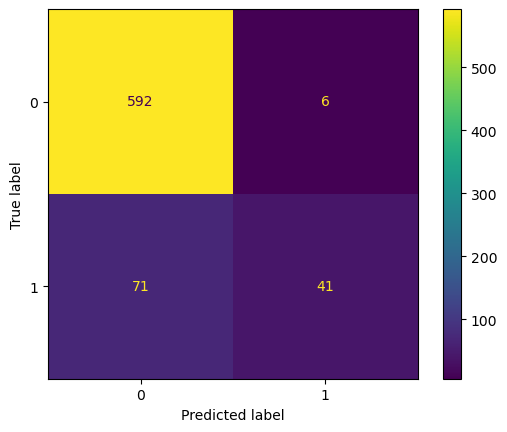

In [109]:
t_nb = MultinomialNB(alpha = 0.5)
t_nb.fit(X_train_vec, y_train)
tnb_pred = nb.predict(X_test_vec)

print(classification_report(y_test, tnb_pred))

tnb_cm = confusion_matrix(y_test, tnb_pred)
ConfusionMatrixDisplay(tnb_cm).plot()

In [110]:
print(t_nb.score(X_train_vec, y_train))
print(t_nb.score(X_test_vec, y_test))

0.9066243833685694
0.8647887323943662


In [111]:
roc_auc_score(y_test, tnb_pred)

0.6780189918776875

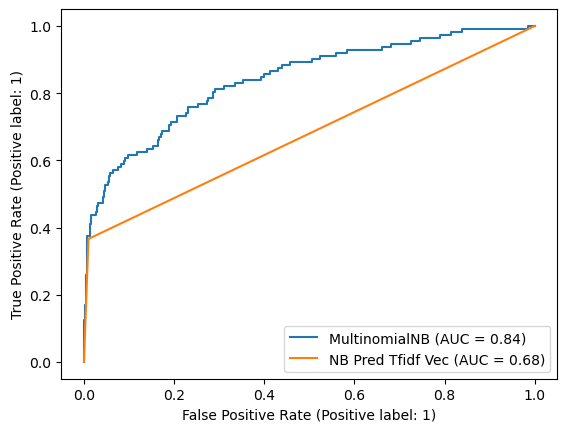

In [112]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(t_nb, X_test_vec, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, tnb_pred ,ax=ax,name="NB Pred Tfidf Vec")

### Gridsearch Tfifd Vectorizer

In [113]:
tfidf_gs = GridSearchCV(SVC(), param_grid, verbose=2)
tfidf_gs.fit(X_train_vec, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.4s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.6s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.5s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.6s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.6s
[CV] END ...................................C=0.1, gamma=1.0; total time=   0.6s
[CV] END ....................................C=0.1, gamma=10; total time=   0.7s
[CV] END ....................................C=0

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1.0, 10, 100],
                         'gamma': [0.1, 1.0, 10, 100]},
             verbose=2)

In [114]:
tfidf_gs.best_params_

{'C': 10, 'gamma': 1.0}

In [115]:
tfidf_gs.best_score_

0.8770269766748641

In [116]:
print(tfidf_gs.score(X_train_vec, y_train))
print(tfidf_gs.score(X_test_vec, y_test))

0.9978858350951374
0.8929577464788733


In [117]:
tfidf_bm = tfidf_gs.best_estimator_
tfidf_bm 

SVC(C=10, gamma=1.0)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       598
           1       0.89      0.37      0.52       112

    accuracy                           0.89       710
   macro avg       0.89      0.68      0.73       710
weighted avg       0.89      0.89      0.87       710



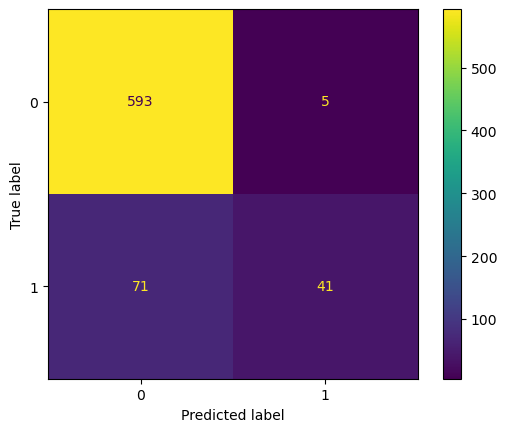

In [118]:
tfidf_bm.fit(X_train_vec, y_train)
tfidf_gs_pred = tfidf_gs.predict(X_test_vec)

print(classification_report(y_test, tfidf_gs_pred))

tfidf_gs_cm = confusion_matrix(y_test, tfidf_gs_pred)
ConfusionMatrixDisplay(tfidf_gs_cm).plot()

In [119]:
print(tfidf_bm.score(X_train_vec, y_train))
print(tfidf_bm.score(X_test_vec, y_test))

0.9978858350951374
0.8929577464788733


In [120]:
roc_auc_score(y_test, tfidf_gs_pred)

0.6788551122790253